In [2]:
import os, math, copy
import matplotlib.pyplot as plt
from pybeta_asymmetry import *
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# Load US Data 
loc = os.getcwd() + "/" 
# stock = pd.read_csv(loc+"Data/CRSP_CLOSE_PP.csv", index_col="date").drop("Unnamed: 0", axis=1)
stock = pd.read_csv(loc+"Data/CRSP_CLOSE_FINAL.csv", index_col="date", date_format="%Y-%m-%d")
market = pd.read_csv(loc+"Data/SPX.csv")[["Date","Close"]]
screen = pd.read_csv(loc+"Data/CRSP_CONSTITUENTS_FINAL.csv", index_col="date", date_format="%Y-%m-%d")
screen = screen.applymap(lambda x: np.nan if x==0 else (int(x) if not math.isnan(x) else np.nan))
stock = np.abs(stock)

### Preprocess Data
stock.index = pd.to_datetime(stock.index, format="%Y%m%d")
market.columns = ["date","CLOSE"]
market.index = pd.to_datetime(market["date"])
market = market.drop("date", axis=1)
screen.index = pd.to_datetime(screen.index)

for col in stock.columns:
    if col not in screen.columns:
        stock = stock.drop(col, axis=1)

for idx in market.index:
    if idx not in stock.index:
        market = market.drop(idx, axis=0)

# Calculate Stock Return
stock_return = stock.pct_change()
market_return = market.pct_change()

dummy_matrix = stock.copy()
dummy_matrix[dummy_matrix.isna() == False] = 0

stock_return = stock_return + dummy_matrix
stock_return = stock_return.dropna(how="all", axis=0)
market_return = market_return.dropna(how="all", axis=0)

# Preprocess 2
for idx in screen.index:
    if idx not in stock_return.index:
        screen = screen.drop(idx, axis=0)

In [5]:
### Winsorize the Stock Return
# winsor_stock_return = PREPROCESSOR.do_winsorize(stock_return, method='quantile', quantile=0.025, hurdle=0.25)
# winsor_stock_return = PREPROCESSOR.replace_extreme(stock_return, 0.5)
winsor_stock_return = stock_return.copy() ### When Using no preprocessed stock return

Please Wait...


Winsorizing...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:03<00:00, 1807.53it/s]


In [ ]:
# Beta Calculation - upBeta
upBeta = BETA_CALCULATOR()
upBeta.run(
    stock_return=winsor_stock_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    market_return=market_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    window=252, # int
    type="up", # str ('up', 'down', 'all')
    white=False, # White Standard Error (used in OLS only)
)
upBeta.beta = upBeta.beta * screen
upBeta.beta.to_csv(loc+"Export/us_upBeta.csv") # Save the Result

In [ ]:
# Beta Calculation - downBeta
downBeta = BETA_CALCULATOR()
downBeta.run(
    stock_return=winsor_stock_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    market_return=market_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    window=252, # int
    type="down", # str ('up', 'down', 'all')
    white=False, # White Standard Error (used in OLS only)
)
downBeta.beta = downBeta.beta * screen
downBeta.beta.to_csv(loc+"Export/us_downBeta.csv") # Save the Result

In [ ]:
### Weight Calculation ###
upbeta_ = pd.read_csv('./Export/us_upBeta.csv', index_col='date', date_format='%Y-%m-%d')
downbeta_ = pd.read_csv('./Export/us_downBeta.csv', index_col='date', date_format='%Y-%m-%d')
myStrategy = STRATEGY()
myStrategy.straddle(
                upbeta=upbeta_,
                downbeta=downbeta_,
                long_stock_down_hurdle=0.85,
                short_stock_up_hurdle=1,#
                up_minus_down_hurdle=0.55,
                down_minus_up_hurdle=0.25
            )

In [377]:
 # Backtesting
pf_return, pf_value = backtesting_sketch(
                            stock_return = stock_return,
                            etf_return = market_return,
                            weight = myStrategy.total_weight,
                            resample = 'w-fri' # Weekly Rebalancing
)


In [378]:
print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return, days=52).values)

Beta-Asymmetry Strategy
CAGR: [0.15103265]
Sharpe: [0.39232738]
MDD: -0.670939134850312
VOL: [0.38496586]


Calculating Momentum...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 66405.01it/s]


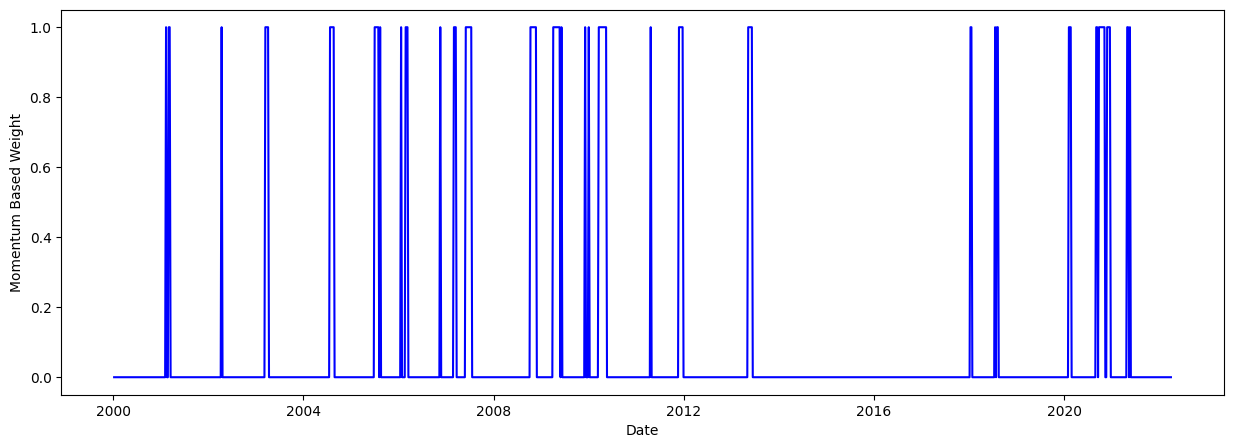

In [370]:
# Calculate Momentum Based Weight from returns of Virtual Portfolio
# Momentums are calucatled automatically without forward looking bias
mom_weight = momentum(
                pf_value = pf_value,
                lookback =10,
                method = 'hurdle_strict', hurdle=0.45)
# Plot Momentum Based Weight for Dynamic Optimization
plt.figure(figsize=(15,5))
plt.xlabel("Date", fontsize=10)
plt.ylabel("Momentum Based Weight", fontsize=10)
plt.plot(mom_weight, color='blue')

In [375]:
# Adjusted resampled weights
filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
momStrategy = STRATEGY()
momStrategy.straddle(
    upbeta=upbeta_,
    downbeta=downbeta_,
    long_stock_down_hurdle=1.2,
    short_stock_up_hurdle=1.2,#
    up_minus_down_hurdle=0.35,
    down_minus_up_hurdle=0.35,
    momentum_weight = filled_weight
)

Please Wait...
(5597,)
(5597, 1)


Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15787.75it/s]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


SnP500 market
CAGR: [0.05297627]
Sharpe: [0.59337333]
MDD: -0.5677538894035712
VOL: [0.08927983]

Beta-Asymmetry Strategy
CAGR: [0.15103265]
Sharpe: [0.39232738]
MDD: -0.670939134850312
VOL: [0.38496586]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.10171351]
Sharpe: [0.38291283]
MDD: -0.45171323994420365
VOL: [0.26563097]


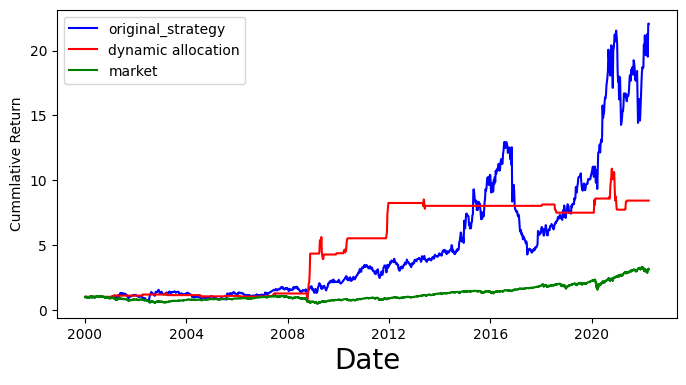

In [372]:
# Backtest the PF
mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return,
                                    etf_return = market_return,
                                    weight = momStrategy.total_weight,
                                    resample = 'w-fri'
                                )

# Plot Cummlative Returns of PFs
# Blue-Virtual_PF, Red-Momentum_Based_Weight_Adjusted PF, Green-S&P500

plt.figure(figsize=(8,4))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Cummlative Return", fontsize=10)

plt.plot((pf_return+1).cumprod(), color='blue')
plt.plot((mom_pf_return+1).cumprod(), color='red')
plt.plot((market_return+1).cumprod(), color='green')
plt.legend(['original_strategy', 'dynamic allocation', 'market'])

print("SnP500 market")
print("CAGR:", cagr(cum(market_return)).values)
print("Sharpe:", sharpe(market_return, days=52).values)
print("MDD:", max_dd(cum(market_return)))
print("VOL:", cagr(cum(market_return)).values / sharpe(market_return, days=52).values)
print()

print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return, days=52).values)

print()
print("Beta-Asymmetry with strategy-based momentum")
print("CAGR:", cagr(cum(mom_pf_return)).values)
print("Sharpe:", sharpe(mom_pf_return, days=52).values)
print("MDD:", max_dd(cum(mom_pf_return)))
print("VOL:", cagr(cum(mom_pf_return)).values / sharpe(mom_pf_return, days=52).values)

plt.show()

2000 ~ 2010
SnP500 market
CAGR: [-0.01448607]
Sharpe: [-0.14576318]
MDD: -0.5677538894035712
VOL: [0.09938083]

Beta-Asymmetry Strategy
CAGR: [0.12517022]
Sharpe: [0.30863622]
MDD: -0.4880511995417284
VOL: [0.40555908]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.18618904]
Sharpe: [0.52124914]
MDD: -0.45171323994420365
VOL: [0.35719778]


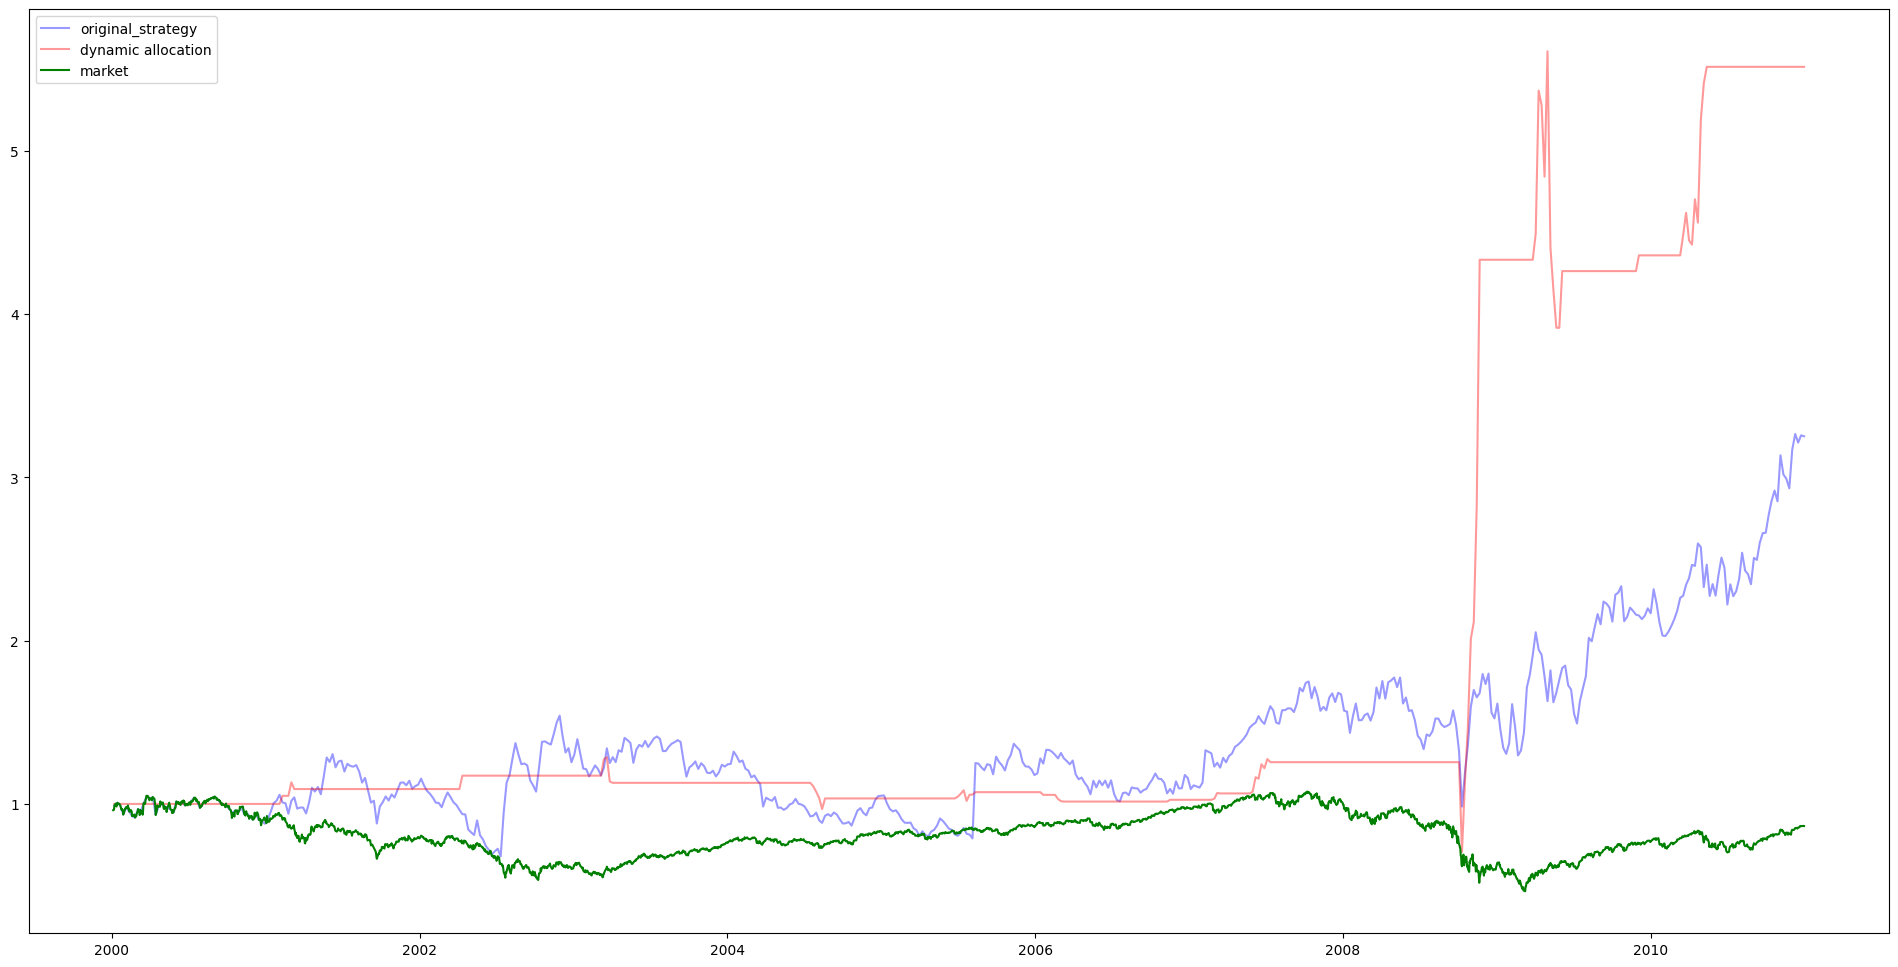

2010 ~ 2020
SnP500 market
CAGR: [0.1291249]
Sharpe: [1.62477187]
MDD: -0.3392495902426059
VOL: [0.07947264]

Beta-Asymmetry Strategy
CAGR: [0.25328342]
Sharpe: [0.7113016]
MDD: -0.6709391348503122
VOL: [0.35608443]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.05962124]
Sharpe: [0.45780675]
MDD: -0.28561369967865746
VOL: [0.13023233]


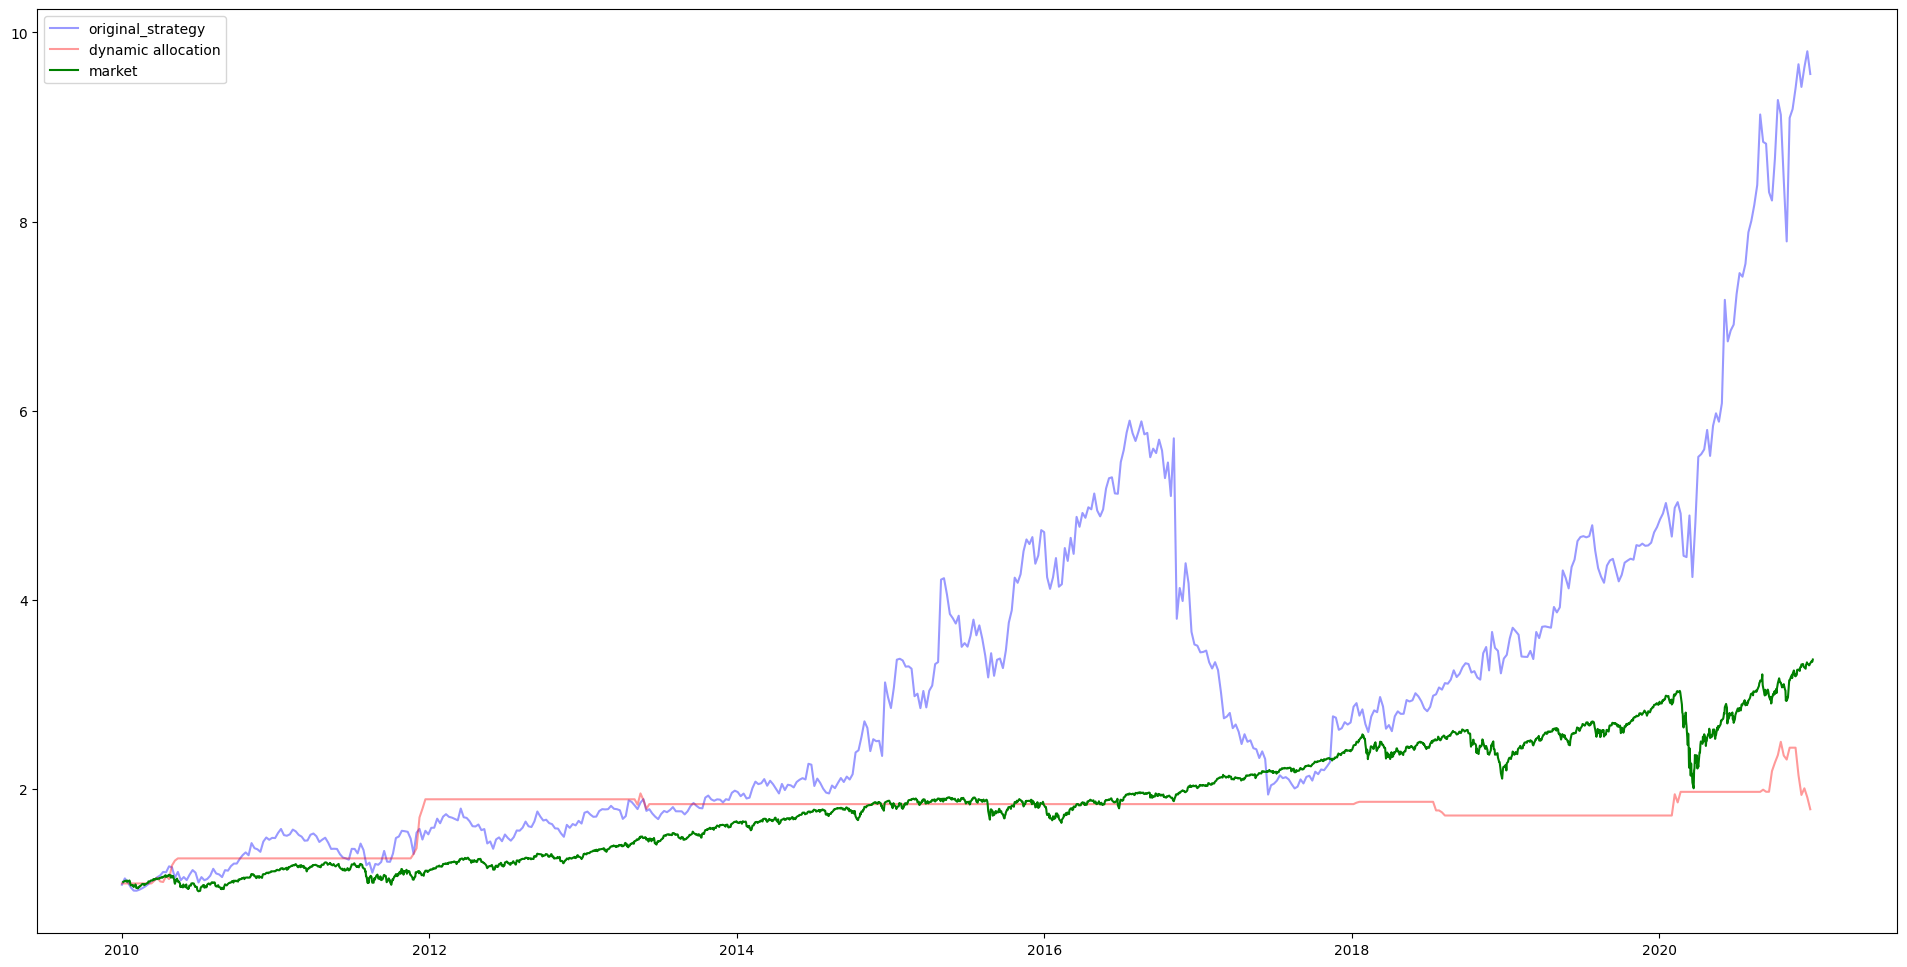

In [373]:
# Visuaized the Periodic Performance of PF
for start_year in [2000,2010]:
    end_year = str(start_year+10)
    start_year = str(start_year)
    print(start_year, "~", end_year)
    print("SnP500 market")
    print("CAGR:", cagr(cum(market_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(market_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(market_return[start_year:end_year])))
    print("VOL:", cagr(cum(market_return[start_year:end_year])).values / sharpe(market_return[start_year:end_year], days=52).values)
    print()

    
    print("Beta-Asymmetry Strategy")
    print("CAGR:", cagr(cum(pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(pf_return[start_year:end_year])).values / sharpe(pf_return[start_year:end_year], days=52).values)
    
    print()
    print("Beta-Asymmetry with strategy-based momentum")
    print("CAGR:", cagr(cum(mom_pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(mom_pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(mom_pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(mom_pf_return[start_year:end_year])).values / sharpe(mom_pf_return[start_year:end_year], days=52).values)
    plt.figure(figsize=(24,12))
    plt.plot((pf_return+1)[start_year:end_year].cumprod(), color='blue', alpha=0.4)
    plt.plot((mom_pf_return+1)[start_year:end_year].cumprod(), color='red', alpha=0.4)
    plt.plot((market_return+1)[start_year:end_year].cumprod(), color='green')
    plt.legend(['original_strategy', 'dynamic allocation', 'market'])
    plt.show()

### greedy search (hyperparameter tuning)

In [280]:
from itertools import product
long_stock_down_hurdle = np.arange(0.85, 1.36, 0.1)
short_stock_up_hurdle = np.arange(1.0, 1.31, 0.1)
up_minus_down_hurdle=np.arange(0.45, 0.66, 0.1)
down_minus_up_hurdle=np.arange(0.1, 0.31, 0.1)
items = [long_stock_down_hurdle, short_stock_up_hurdle, up_minus_down_hurdle, down_minus_up_hurdle]
all_comb = list(product(*items))
print(len(all_comb))

216


In [ ]:
maxi = -100
mini = -100
comb = all_comb[0]
for x in tqdm(all_comb):
    myStrategy = STRATEGY()
    myStrategy.straddle(
                    upbeta=upbeta_,
                    downbeta=downbeta_,
                    long_stock_down_hurdle=x[0],
                    short_stock_up_hurdle=x[1],
                    up_minus_down_hurdle=x[2],
                    down_minus_up_hurdle=x[3]
                )
    pf_return, pf_value = backtesting_sketch(
                            stock_return = stock_return,
                            etf_return = market_return,
                            weight = myStrategy.total_weight,
                            resample = 'w-fri' # Weekly Rebalancing
    )
    sharpe_ = sharpe(pf_return, days=52).values[0]
    mdd_ = max_dd(cum(pf_return))
    if (sharpe_ >= maxi):
        maxi = sharpe_
        mini = mdd_
        comb = x

In [396]:
from itertools import product
methods = ['hurdle_strict', 'hurdle_smooth']
hurdle = np.arange(0.4, 0.66, 0.05)
long_stock_down_hurdle = np.arange(1, 1.31, 0.1)
short_stock_up_hurdle = np.arange(0.85, 1.36, 0.1)
up_minus_down_hurdle=np.arange(0.45, 0.76, 0.1)
down_minus_up_hurdle=np.arange(0.4, 0.41, 0.1)
items = [methods, hurdle, long_stock_down_hurdle, short_stock_up_hurdle, up_minus_down_hurdle, down_minus_up_hurdle]
all_comb = list(product(*items))
print(len(all_comb))

1152


In [ ]:
maxi = -100
mini = -100
comb = all_comb[0]
all_comb_mom_pf_return = []
for x in tqdm(all_comb):
    # Adjusted resampled weights
    mom_weight = momentum(
                pf_value = pf_value,
                lookback =10,  # 10weeks rolling
                method = x[0], hurdle=x[1])
    filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
    momStrategy = STRATEGY()
    momStrategy.straddle(
        upbeta=upbeta_,
        downbeta=downbeta_,
        long_stock_down_hurdle=x[2],
        short_stock_up_hurdle=x[3],
        up_minus_down_hurdle=x[4],
        down_minus_up_hurdle=x[5],
        momentum_weight = filled_weight
    )
    mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return,
                                    etf_return = market_return,
                                    weight = momStrategy.total_weight,
                                    resample = 'w-fri'
                                )
    sharpe_ = sharpe(mom_pf_return, days=52).values[0]
    mdd_ = max_dd(cum(mom_pf_return))
    all_comb_mom_pf_return.append([x, sharpe_, mdd_])
    if (sharpe_ >= maxi):
        maxi = sharpe_
        mini = mdd_
        comb = x

In [398]:
print(maxi, mini, comb)

0.45989197044177665 -0.5138840978643942 ('hurdle_smooth', 0.6, 1.1, 0.95, 0.45, 0.4)


Calculating Momentum...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 66481.82it/s]


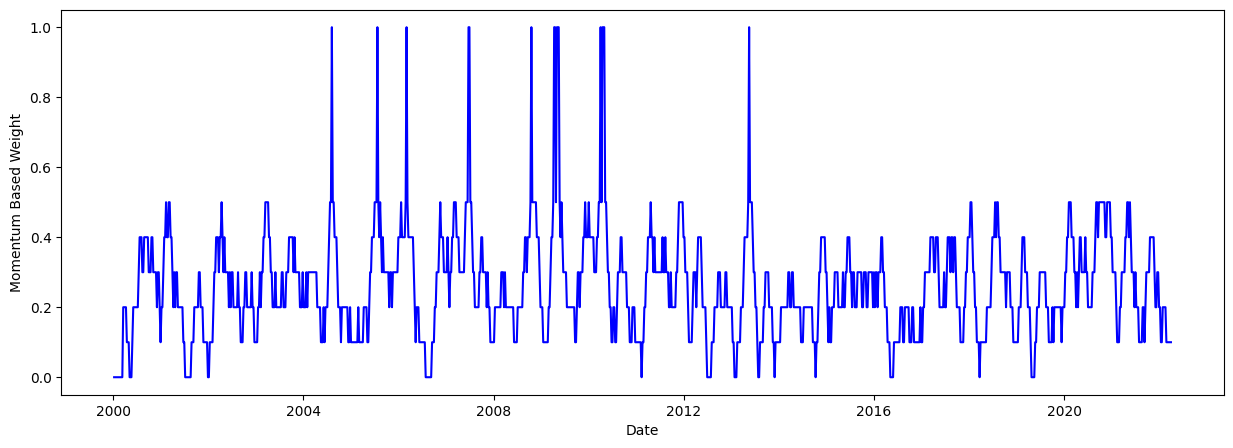

In [399]:
# Calculate Momentum Based Weight from returns of Virtual Portfolio
# Momentums are calucatled automatically without forward looking bias
mom_weight = momentum(
                pf_value = pf_value,
                lookback =10,
                method = 'hurdle_smooth', hurdle=0.6)
# Plot Momentum Based Weight for Dynamic Optimization
plt.figure(figsize=(15,5))
plt.xlabel("Date", fontsize=10)
plt.ylabel("Momentum Based Weight", fontsize=10)
plt.plot(mom_weight, color='blue')

In [400]:
# Adjusted resampled weights
filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
momStrategy = STRATEGY()
momStrategy.straddle(
    upbeta=upbeta_,
    downbeta=downbeta_,
    long_stock_down_hurdle=1.1,
    short_stock_up_hurdle=0.95,#
    up_minus_down_hurdle=0.45,
    down_minus_up_hurdle=0.4,
    momentum_weight = filled_weight
)

Please Wait...
(5597,)
(5597, 1)


Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12725.62it/s]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


SnP500 market
CAGR: [0.05297627]
Sharpe: [0.59337333]
MDD: -0.5677538894035712
VOL: [0.08927983]

Beta-Asymmetry Strategy
CAGR: [0.15103265]
Sharpe: [0.39232738]
MDD: -0.670939134850312
VOL: [0.38496586]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.09549232]
Sharpe: [0.45989197]
MDD: -0.5138840978643942
VOL: [0.20764076]


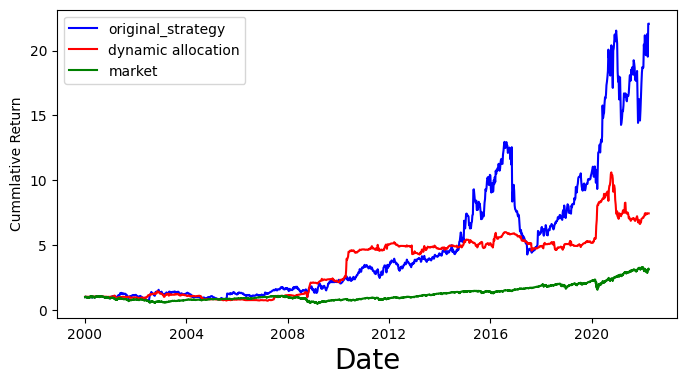

In [401]:
# Backtest the PF
mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return,
                                    etf_return = market_return,
                                    weight = momStrategy.total_weight,
                                    resample = 'w-fri'
                                )

# Plot Cummlative Returns of PFs
# Blue-Virtual_PF, Red-Momentum_Based_Weight_Adjusted PF, Green-S&P500

plt.figure(figsize=(8,4))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Cummlative Return", fontsize=10)

plt.plot((pf_return+1).cumprod(), color='blue')
plt.plot((mom_pf_return+1).cumprod(), color='red')
plt.plot((market_return+1).cumprod(), color='green')
plt.legend(['original_strategy', 'dynamic allocation', 'market'])

print("SnP500 market")
print("CAGR:", cagr(cum(market_return)).values)
print("Sharpe:", sharpe(market_return, days=52).values)
print("MDD:", max_dd(cum(market_return)))
print("VOL:", cagr(cum(market_return)).values / sharpe(market_return, days=52).values)
print()

print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return, days=52).values)

print()
print("Beta-Asymmetry with strategy-based momentum")
print("CAGR:", cagr(cum(mom_pf_return)).values)
print("Sharpe:", sharpe(mom_pf_return, days=52).values)
print("MDD:", max_dd(cum(mom_pf_return)))
print("VOL:", cagr(cum(mom_pf_return)).values / sharpe(mom_pf_return, days=52).values)

plt.show()

2000 ~ 2010
SnP500 market
CAGR: [-0.01448607]
Sharpe: [-0.14576318]
MDD: -0.5677538894035712
VOL: [0.09938083]

Beta-Asymmetry Strategy
CAGR: [0.12517022]
Sharpe: [0.30863622]
MDD: -0.4880511995417284
VOL: [0.40555908]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.16624269]
Sharpe: [0.69460543]
MDD: -0.5138840978643942
VOL: [0.23933399]


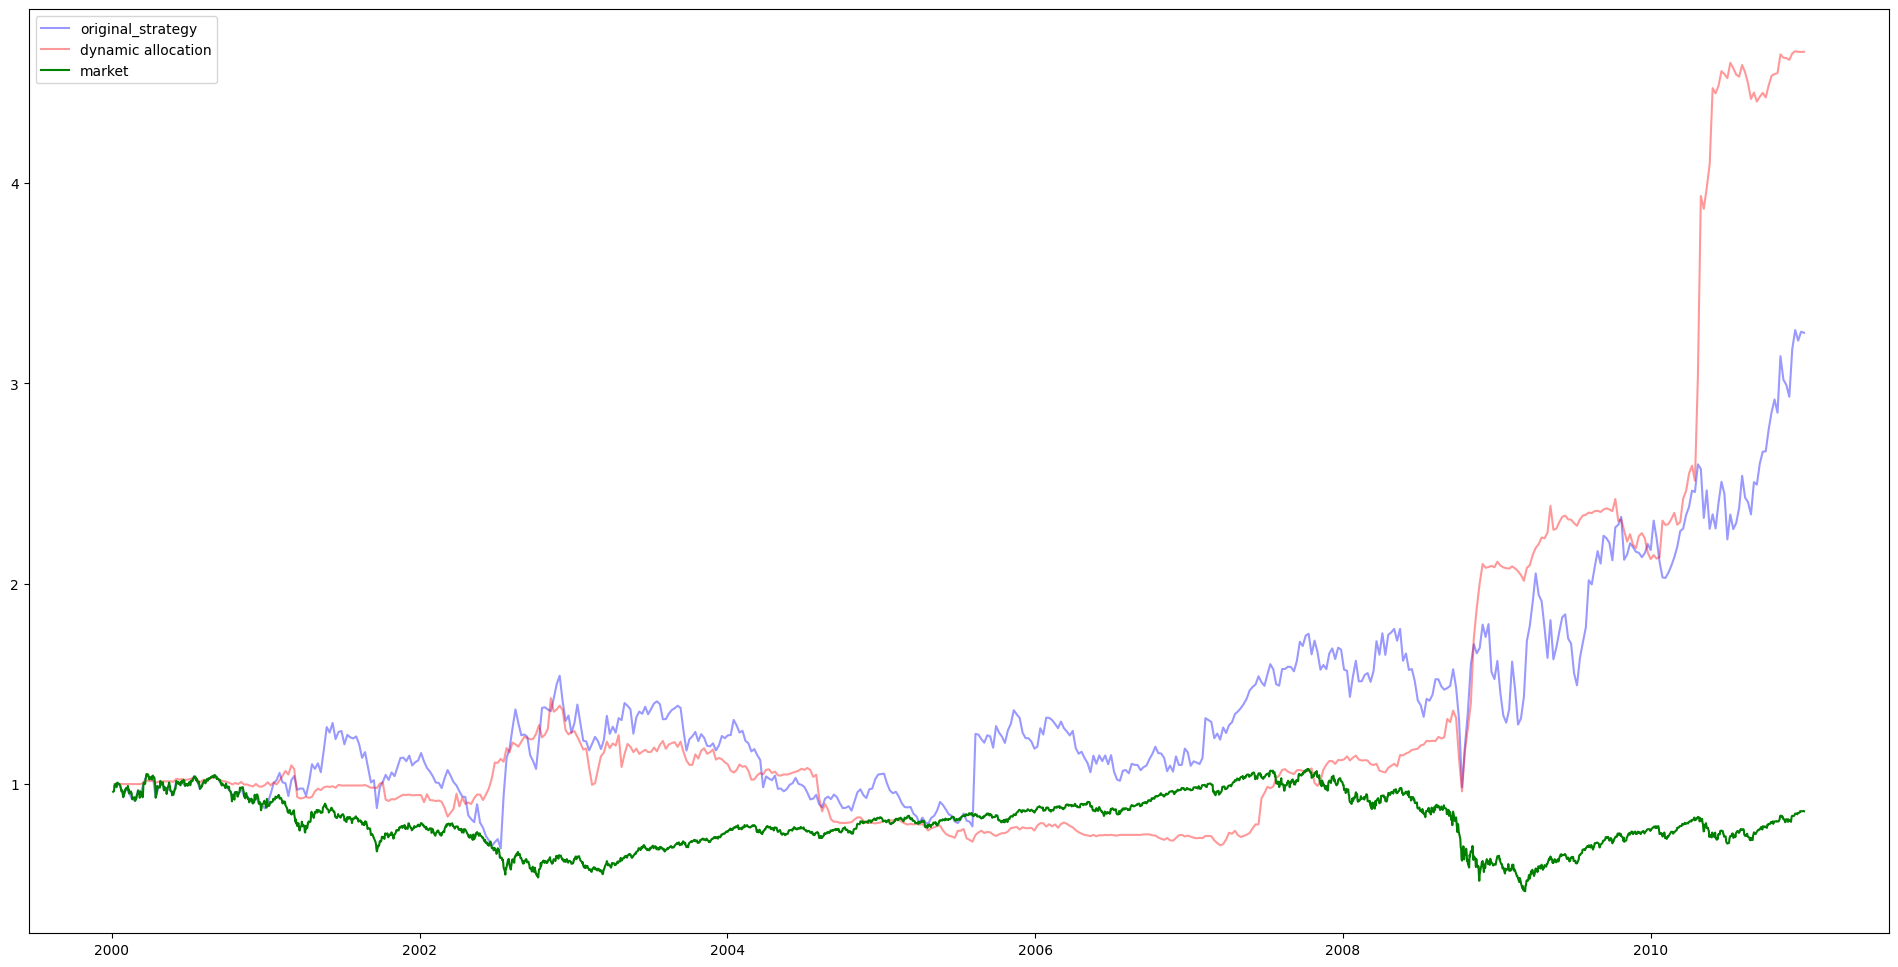

2010 ~ 2020
SnP500 market
CAGR: [0.1291249]
Sharpe: [1.62477187]
MDD: -0.3392495902426059
VOL: [0.07947264]

Beta-Asymmetry Strategy
CAGR: [0.25328342]
Sharpe: [0.7113016]
MDD: -0.6709391348503122
VOL: [0.35608443]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.13075815]
Sharpe: [0.65257831]
MDD: -0.30527967469524264
VOL: [0.20037158]


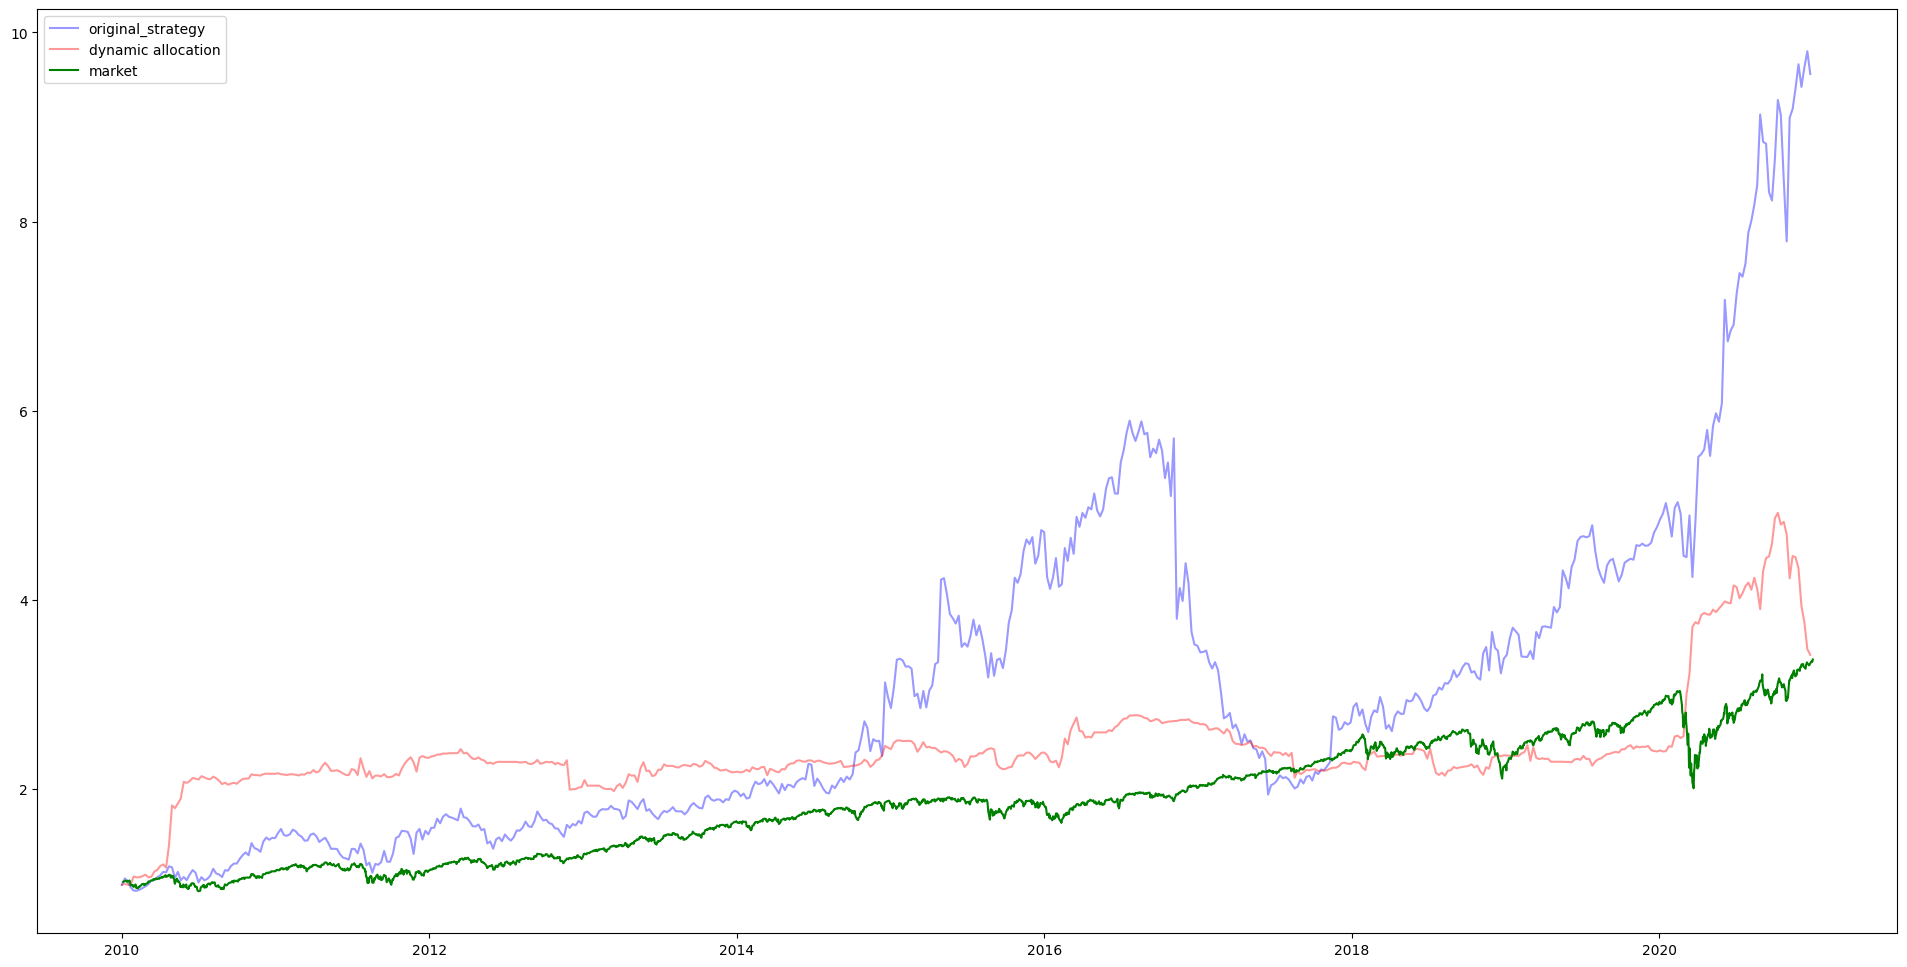

In [402]:
# Visuaized the Periodic Performance of Real PF
for start_year in [2000,2010]:
    end_year = str(start_year+10)
    start_year = str(start_year)
    print(start_year, "~", end_year)
    print("SnP500 market")
    print("CAGR:", cagr(cum(market_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(market_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(market_return[start_year:end_year])))
    print("VOL:", cagr(cum(market_return[start_year:end_year])).values / sharpe(market_return[start_year:end_year], days=52).values)
    print()

    
    print("Beta-Asymmetry Strategy")
    print("CAGR:", cagr(cum(pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(pf_return[start_year:end_year])).values / sharpe(pf_return[start_year:end_year], days=52).values)
    
    print()
    print("Beta-Asymmetry with strategy-based momentum")
    print("CAGR:", cagr(cum(mom_pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(mom_pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(mom_pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(mom_pf_return[start_year:end_year])).values / sharpe(mom_pf_return[start_year:end_year], days=52).values)
    plt.figure(figsize=(24,12))
    plt.plot((pf_return+1)[start_year:end_year].cumprod(), color='blue', alpha=0.4)
    plt.plot((mom_pf_return+1)[start_year:end_year].cumprod(), color='red', alpha=0.4)
    plt.plot((market_return+1)[start_year:end_year].cumprod(), color='green')
    plt.legend(['original_strategy', 'dynamic allocation', 'market'])
    plt.show()